Trying a = 2...
Trying a = 4...
Trying a = 7...
Trying a = 8...
Trying a = 11...
Shor’s Algorithm found factors: 5 and 3


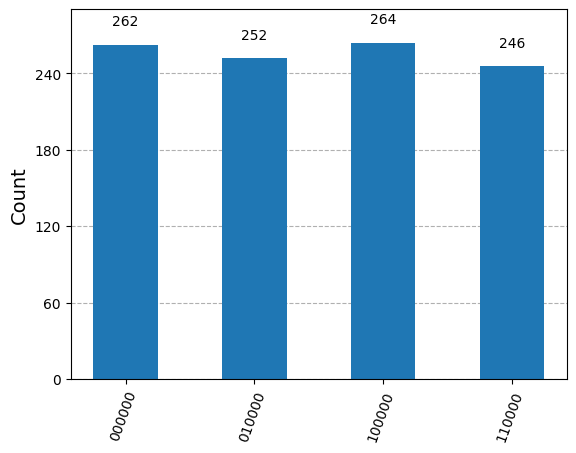

In [2]:
# Import necessary Qiskit libraries
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer  # Fixed import
from fractions import Fraction
import numpy as np
import math  

# Define the inverse Quantum Fourier Transform (QFT†)
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / float(2 ** (j - k)), k, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

# Define modular exponentiation as a quantum circuit (Fixed)
def modular_exponentiation(a, power, N):
    qc = QuantumCircuit(4)  # Only 4 data qubits (control will be added later)

    for _ in range(power):
        if a in [2, 13]:  
            qc.swap(0, 1)
            qc.swap(1, 2)
            qc.swap(2, 3)
        elif a in [4, 11]:  
            qc.swap(2, 3)
            qc.swap(1, 2)
            qc.swap(0, 1)
        elif a in [7, 8]:  
            qc.swap(1, 3)
            qc.swap(0, 2)

    # **Apply control gate** (Fixing the qubit mismatch issue)
    controlled_qc = qc.control(1)  # Convert to controlled operation
    return controlled_qc  # Return the controlled operation

# Define the Quantum Phase Estimation circuit for a^x mod N (Fixed)
def qpe_amodN(a, N):
    qc = QuantumCircuit(10, 6)  # 6 counting qubits, 4 computational qubits
    qc.h(range(6))  # Apply Hadamard to counting qubits
    qc.x(6)  # Initialize |1> state for modular exponentiation

    for q in range(6):
        qc.append(modular_exponentiation(a, 2**q, N), 
                  [q] + list(range(6, 10)))  # Corrected argument list

    qc.append(qft_dagger(6), range(6))  # Apply inverse QFT
    qc.measure(range(6), range(6))  # Measure first 6 qubits
    return qc

# Classical function to compute factors using period r
def find_factors(a, N, r):
    if r % 2 == 1 or r == 0:
        return None  # We need an even r
    factor1 = math.gcd(a ** (r // 2) - 1, N)
    factor2 = math.gcd(a ** (r // 2) + 1, N)
    if factor1 in [1, N] or factor2 in [1, N]:
        return None  # No non-trivial factors found
    return factor1, factor2

# Example: Breaking RSA-15 (N=15)
N = 15  # RSA modulus (product of 3 and 5)
np.random.seed(1)
valid_factors = None
backend = Aer.get_backend('aer_simulator')

for a in [2, 4, 7, 8, 11, 13]:
    if math.gcd(a, N) > 1:
        print(f"Trivial factor found: {math.gcd(a, N)}")
        continue
    print(f"Trying a = {a}...")
    qc = qpe_amodN(a, N)
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=1024).result()
    counts = result.get_counts()
    if counts:
        measured_phase = max(counts, key=counts.get)
        decimal_phase = int(measured_phase, 2) / (2**6)
        fraction = Fraction(decimal_phase).limit_denominator(2**6)
        r = fraction.denominator
        factors = find_factors(a, N, r)
        if factors:
            valid_factors = factors
            break
    else:
        print("No measurement results. Trying next value of a...")

if valid_factors:
    print(f"Shor’s Algorithm found factors: {valid_factors[0]} and {valid_factors[1]}")
else:
    print("Shor’s Algorithm failed. Try again with a different N.")

plot_histogram(counts)

#DEMONSTRATION 2 : THIS PROGRAM HAS CRACKED RSA-15 USING THE AER-SIMULATOR